## Problem Statement ( Kaggle Link <a href='https://www.kaggle.com/c/house-prices-advanced-regression-techniques'> here</a> )

### Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format
The file should contain a header and have the following format:

Id,SalePrice <br>
1461,169000.1 <br>
1462,187724.1233 <br>
1463,175221 <br>
etc.

## Solution

In [1]:
# remove warning throughout the notebook
import warnings
warnings.filterwarnings('ignore')

# packages for dataframe and data
import pandas as pd
import numpy as np
import math
# packages for visualizations / eda
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.express as px
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs,init_notebook_mode, plot,iplot
from plots.sns import PlotUtil
# packages for preprocessing
from preprocessing.memory import MemoryUtil
from preprocessing.nv import NVUtil
from preprocessing.label_encoder import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from preprocessing.outlier import OutlierUtil
from preprocessing.scalar import ScalarUtil
from sklearn.preprocessing import StandardScaler

#packages for feature selection
from feature_engineering import FeatureSelectionUtil
#model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.model_selection import GridSearchCV

#model metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error
from metrics import RegressionMetricsUtil

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
# Kaggle - house price advanced regression techniques
train_df = pd.read_csv(r"D:\sanooj\datascience\data\house-prices-advanced-regression-techniques\train.csv")
test_df = pd.read_csv(r"D:\sanooj\datascience\data\house-prices-advanced-regression-techniques\test.csv")

In [3]:
train_df.shape

(1460, 81)

### Pre Processing
#### Memory Optimization

In [4]:
train_df = MemoryUtil.memory_optimize(train_df)

Memory usage before optimization is: 0.90 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%


In [5]:
test_df = MemoryUtil.memory_optimize(test_df)

Memory usage before optimization is: 0.89 MB
Memory usage after optimization is: 0.16 MB
Decreased by 81.7%


#### Get to know each numeric column

In [6]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.0,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,inf,10516.828082,6.099315,5.575342,1971.267808,1984.865753,inf,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.296875,9981.264932,1.382997,1.112799,30.202904,20.645407,inf,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.0,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.0,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.0,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Check for columns having null values and treat them

In [8]:
train_df.columns[train_df.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [9]:
excluded_columns_train,selected_columns_train,numerical_columns_train,categorical_columns_train,train_df = NVUtil.nv_treatment(train_df,30)


Before NV treatment the stats are as below
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64
Before NV treatment the stats are as below
Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64


In [10]:
excluded_columns_train

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [11]:
excluded_columns_test,selected_columns_test,numerical_columns_test,categorical_columns_test,test_df = NVUtil.nv_treatment(test_df,30)


Before NV treatment the stats are as below
Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64
Before NV treatment the stats are as below
Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 75, dtype: int64


In [12]:
excluded_columns_test

Index(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [13]:
categorical_columns_train

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [14]:
train_df.columns[train_df.isnull().any()]

Index([], dtype='object')

In [15]:
test_df.columns[test_df.isnull().any()]

Index([], dtype='object')

#### Label Encoding

In [16]:
train_df=pd.get_dummies(data=train_df, columns=categorical_columns_train)
test_df=pd.get_dummies(data=test_df, columns=categorical_columns_train)

In [17]:
train_df.shape,test_df.shape

((1460, 272), (1459, 255))

In [18]:
### Some dummy variables got missed in test data set
test_cols = test_df.columns.values
missing = []
for i in train_df.columns:
    if i == 'SalePrice':
        continue
    
    if i not in test_cols:
        test_df[i] = np.zeros(test_df.shape[0])   


In [19]:
#train_df,test_df = LabelEncoder.encode_train_test(train_df,test_df,categorical_columns_train)

In [20]:
train_df.shape,test_df.shape

((1460, 272), (1459, 271))

In [21]:
all_cat_columns = []
for i in train_df.columns:
    type = i.split('_')[0]
    if type in categorical_columns_train:
        all_cat_columns.append(i)
        
all_cat_columns

['MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst

#### Outlier Treatment

In [22]:
train_df = OutlierUtil.iqr_outlier_treatment(train_df,numerical_columns_train)


Before iqr outler treatment the stats are as below
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000   1460.00000    1460.000000  1460.000000   
mean    730.500000    56.897260          inf   10516.828082     6.099315   
std     421.610009    42.300571     22.03125    9981.264932     1.382997   
min       1.000000    20.000000     21.00000    1300.000000     1.000000   
25%     365.750000    20.000000     60.00000    7553.500000     5.000000   
50%     730.500000    50.000000     69.00000    9478.500000     6.000000   
75%    1095.250000    70.000000     79.00000   11601.500000     7.000000   
max    1460.000000   190.000000    313.00000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd  MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000     1460.00  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753         inf   443.639726  ...   
std       1.112799    30.2

In [23]:
test_df = OutlierUtil.iqr_outlier_treatment(test_df,numerical_columns_test)


Before iqr outler treatment the stats are as below
                Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000    1459.0000   1459.000000  1459.000000   
mean   2190.000000    57.378341          inf   9819.161069     6.078821   
std     421.321334    42.746880      20.5625   4955.517327     1.436812   
min    1461.000000    20.000000      21.0000   1470.000000     1.000000   
25%    1825.500000    20.000000      60.0000   7391.000000     5.000000   
50%    2190.000000    50.000000      67.0000   9399.000000     6.000000   
75%    2554.500000    70.000000      78.0000  11517.500000     7.000000   
max    2919.000000   190.000000     200.0000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  \
count  1459.000000  1459.000000   1459.000000      1459.0      1459.0  ...   
mean      5.553804  1971.357779   1983.662783         inf         inf  ...   
std       1.113740    30.390071     21

#### Standard Scalar

In [24]:
skip_columns = ['Id','SalePrice']
train_df,test_df = ScalarUtil.standard_scalar_train_test(train_df,test_df,numerical_columns_train,skip_columns)

In [25]:
#transform_target_variable = False
#if transform_target_variable == True:
    #mms = StandardScaler()
    #mms.fit(train_df[['SalePrice']])
    #x = mms.transform(train_df[['SalePrice']])
    #train_df['SalePrice'] = x

#### MinMax Scalar

In [26]:
#train_df,test_df = ScalarUtil.min_max_scalar_train_test(train_df,test_df,numerical_columns_train,skip_columns)

### Visualizations

In [27]:
numerical_columns_train

array(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'], dtype=object)

##### Let's check how normally disributed are the fields

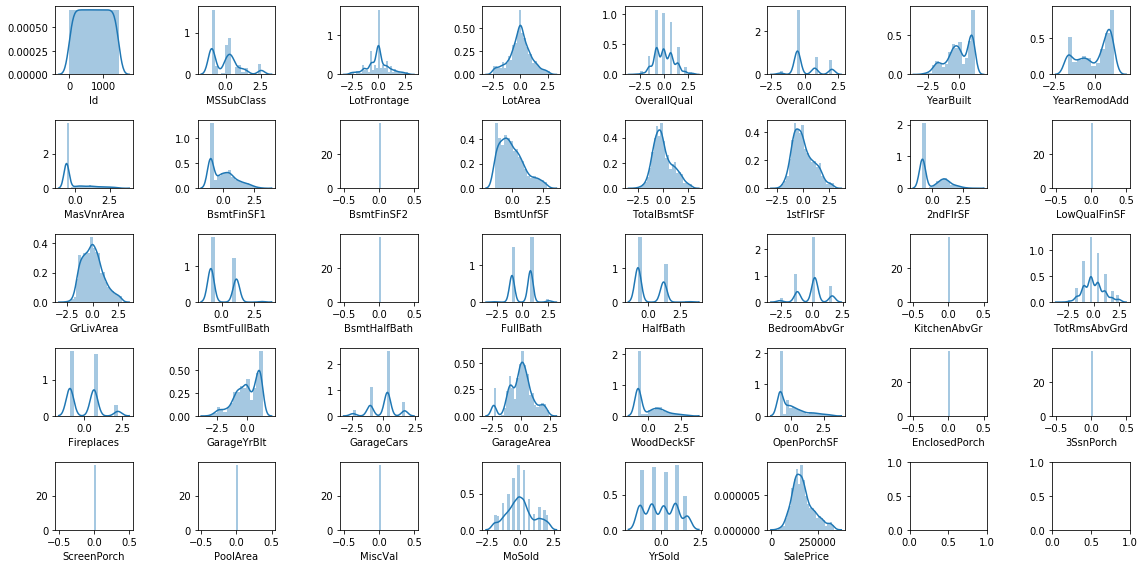

In [28]:
rows = 5
columns = 8
figsize = (16,8)
PlotUtil.draw_distribution_plot(rows,columns,train_df,figsize,numerical_columns_train)

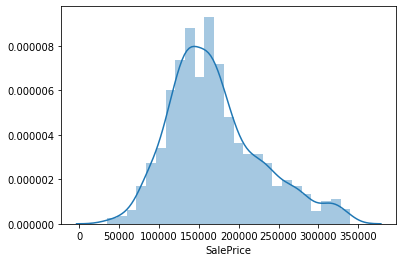

In [29]:
sns.distplot(train_df['SalePrice'])

###### Plot Interpretation

Following plots looks decently normally disributed
- LotFrontage
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- KitchenAbvGr
- TotRmsAbvGrd
- GarageArea
- MoSold
- SalePrice

##### Let's check the scatter plots for these variables

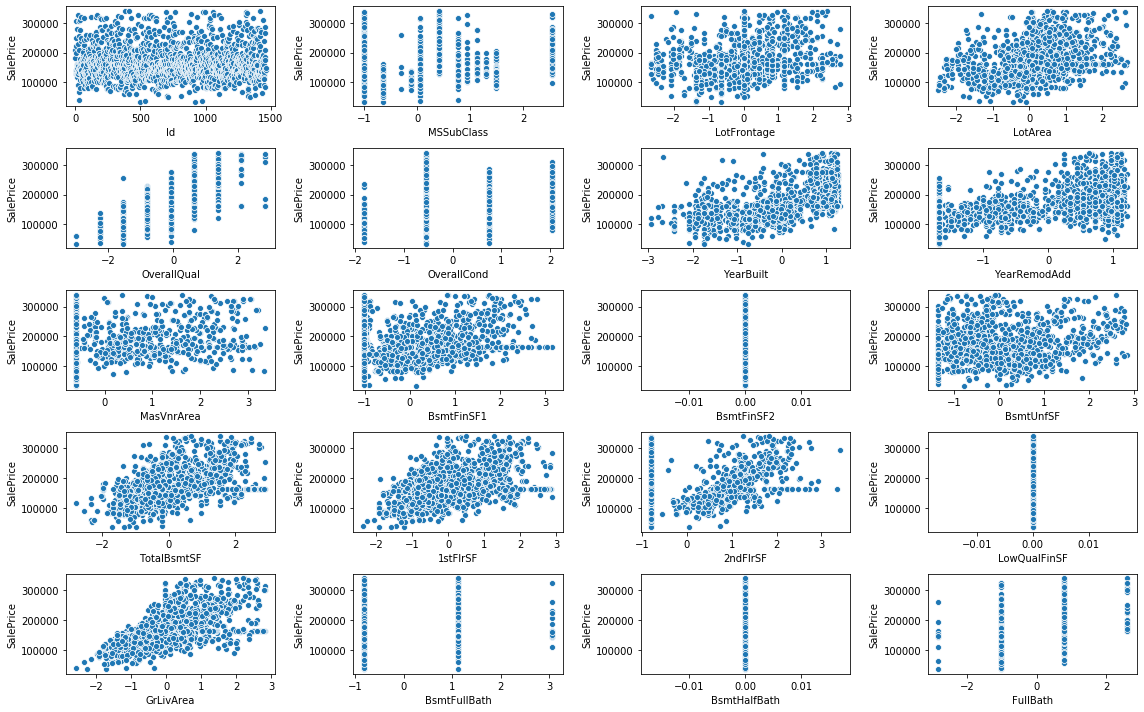

In [30]:
rows = 5
columns = 4
figsize = (16,10)
target_variable = 'SalePrice'
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[0:20])

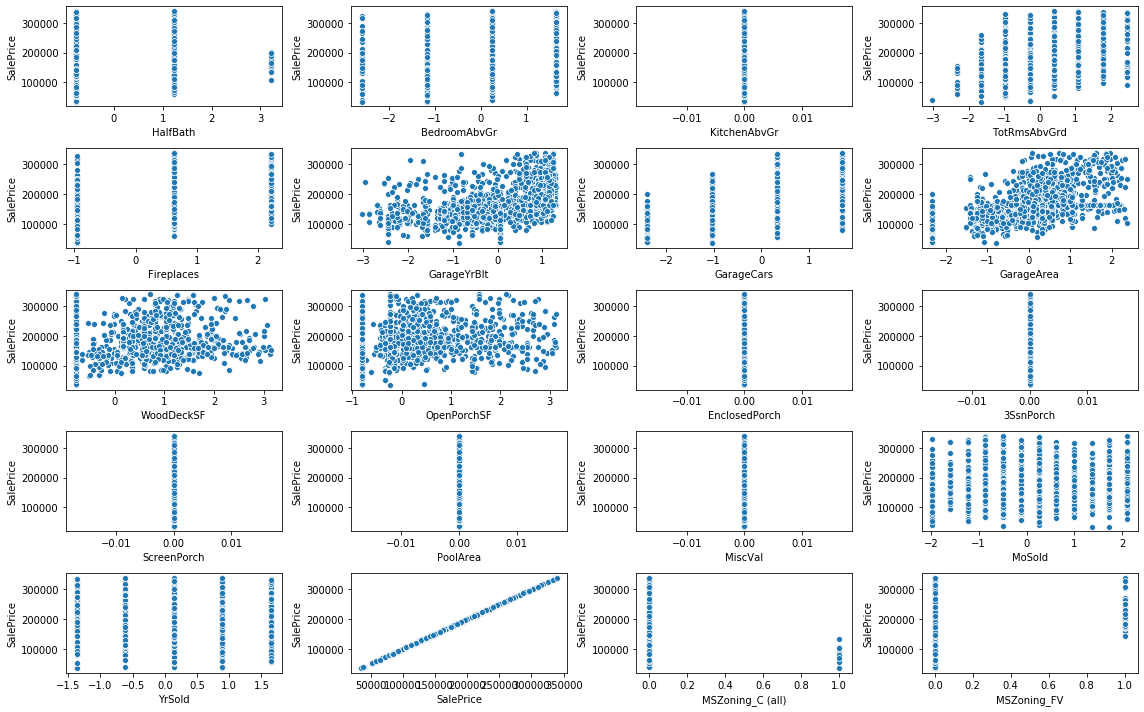

In [31]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[20:40])

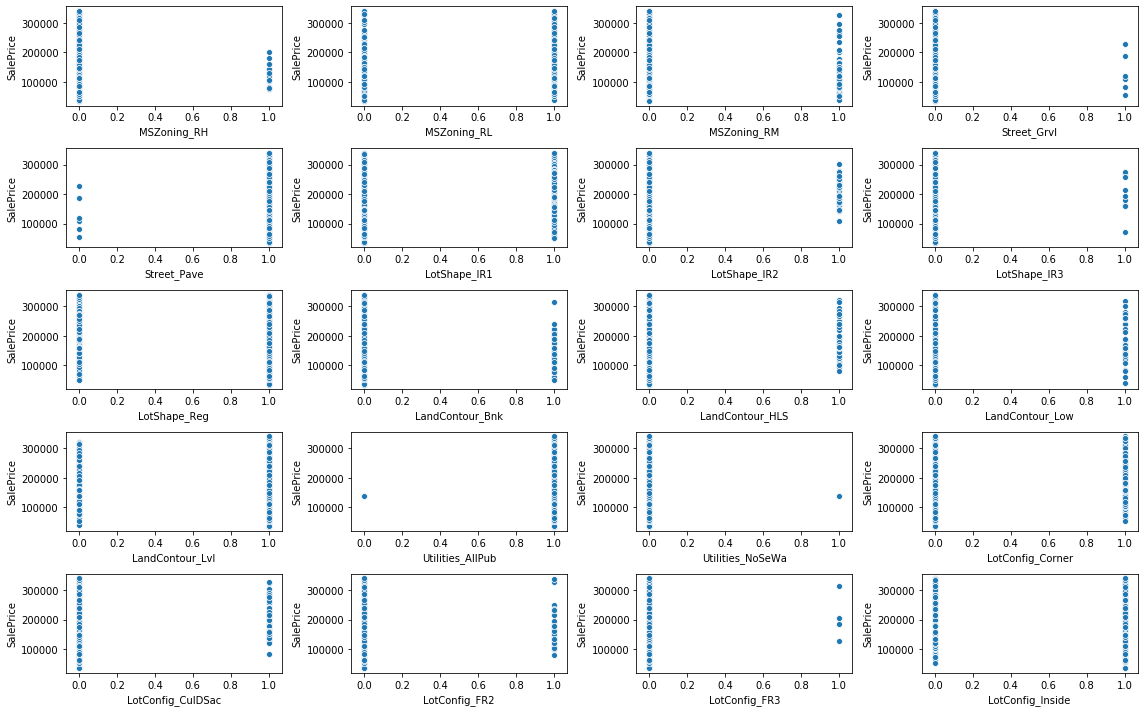

In [32]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[40:60])

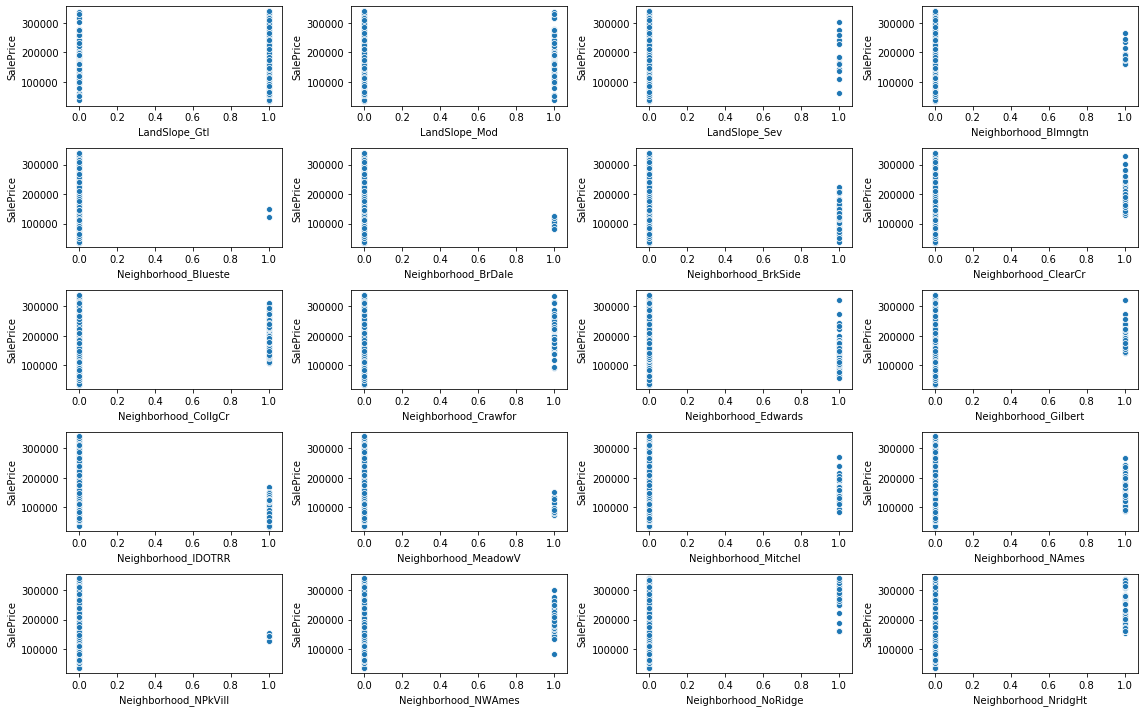

In [33]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[60:80])

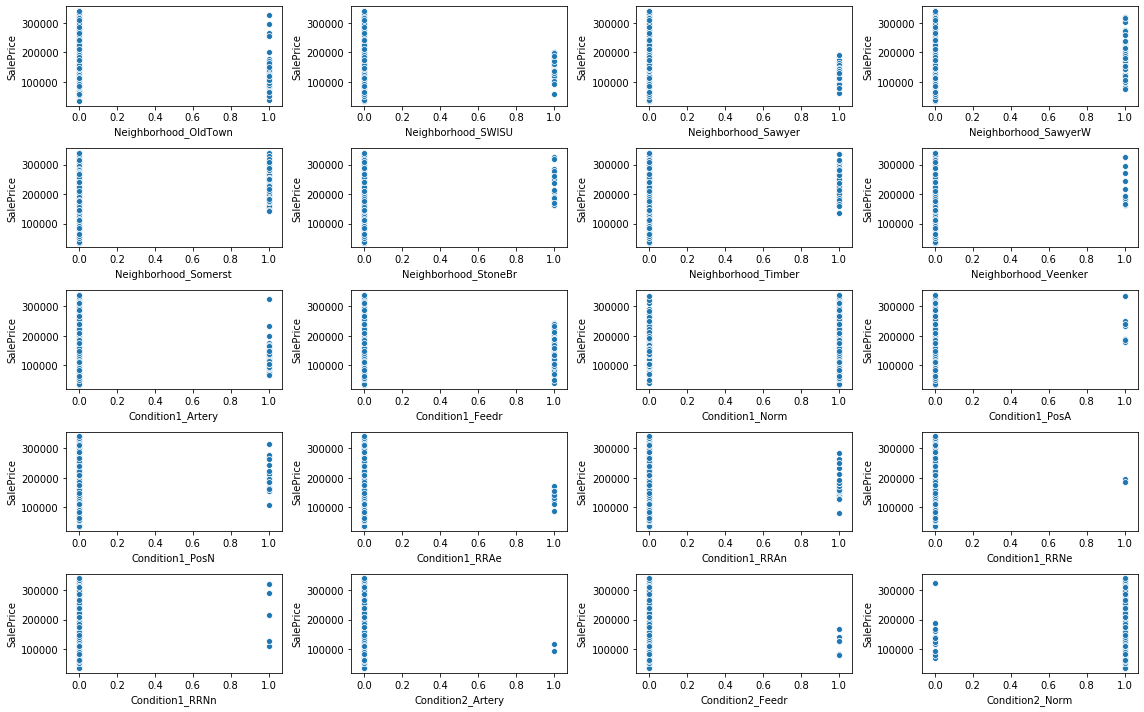

In [34]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[80:100])

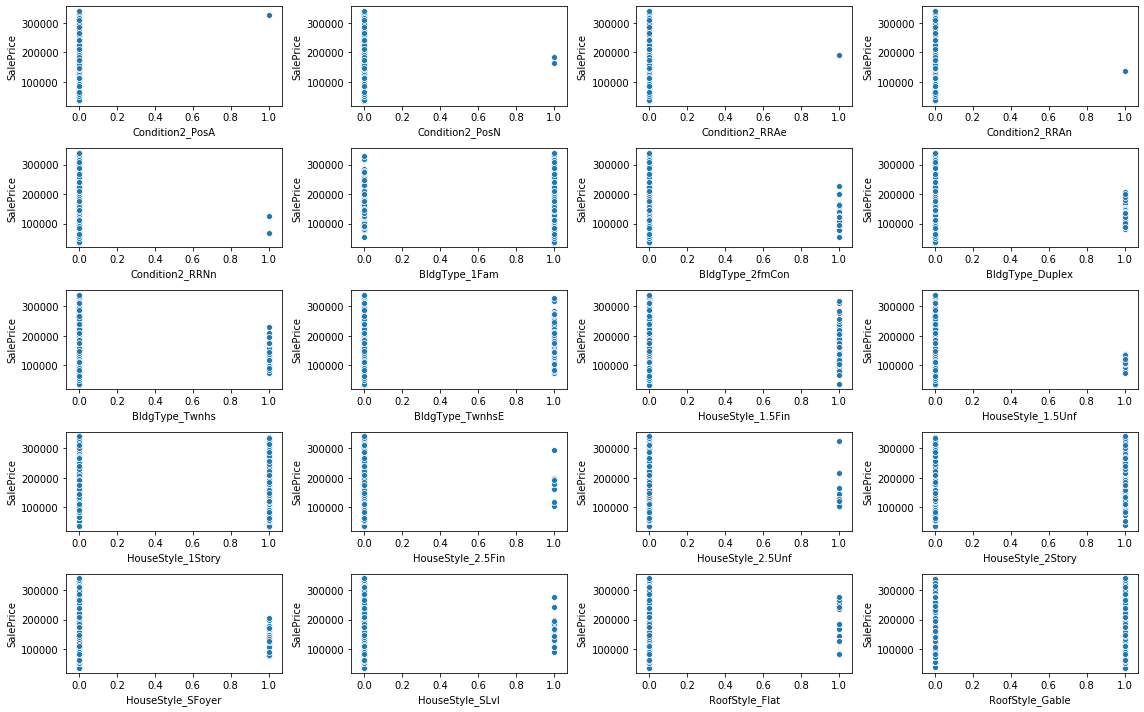

In [35]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[100:120])

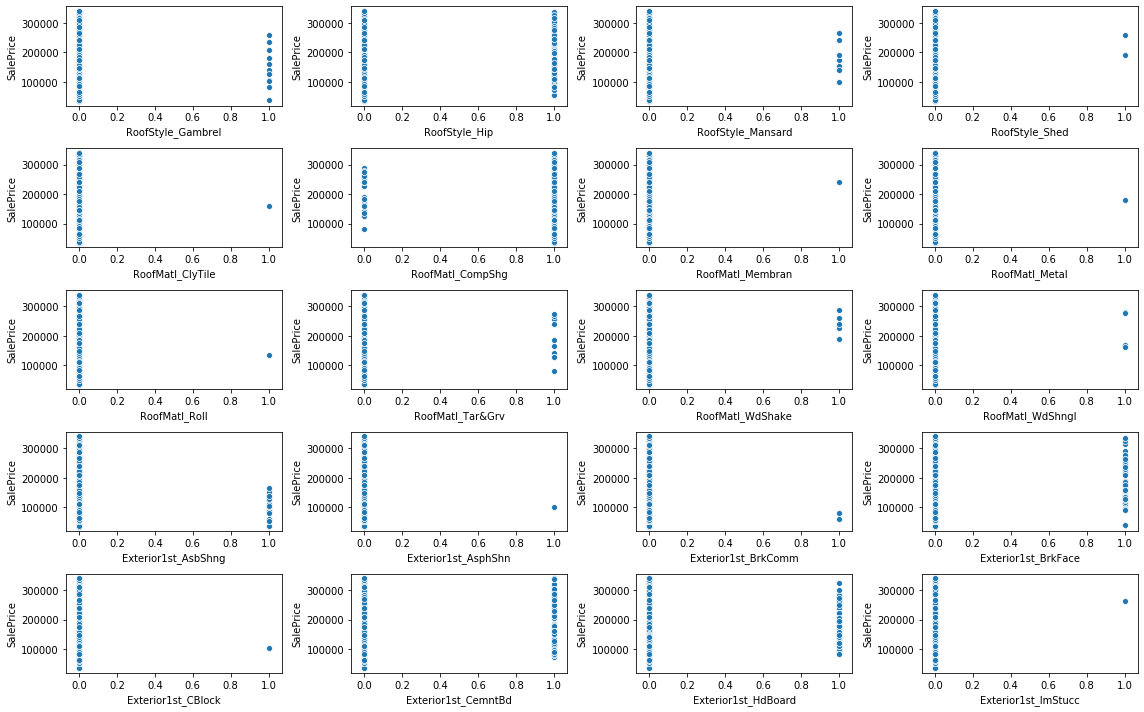

In [36]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[120:140])

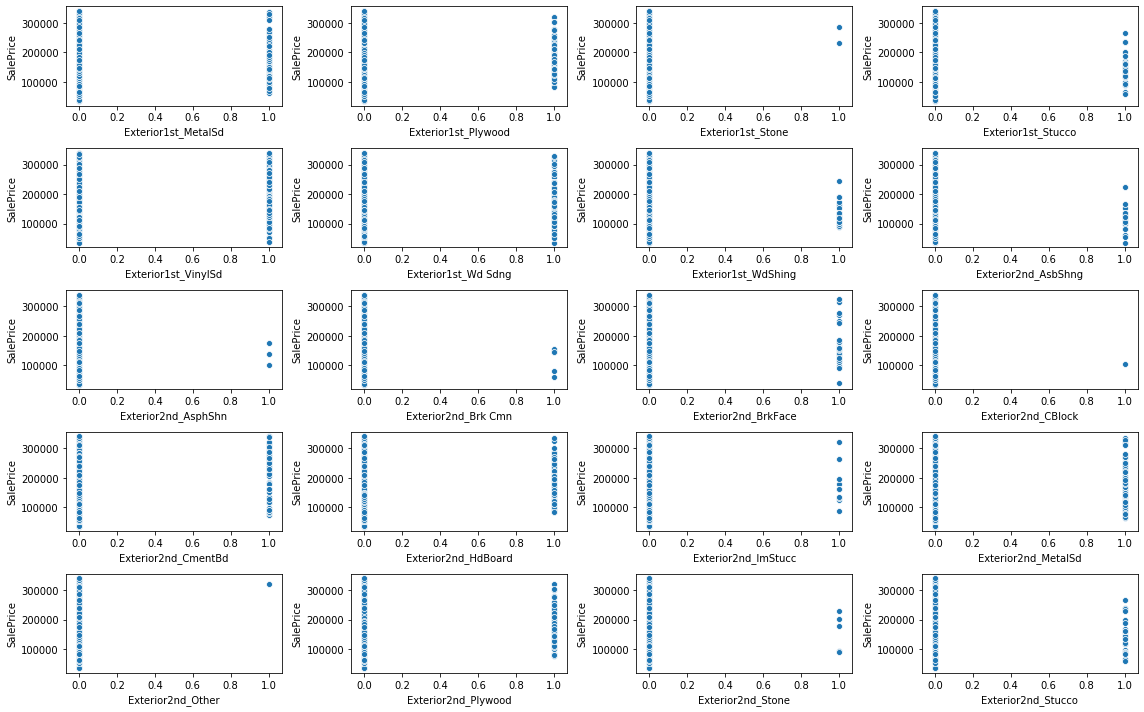

In [37]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[140:160])

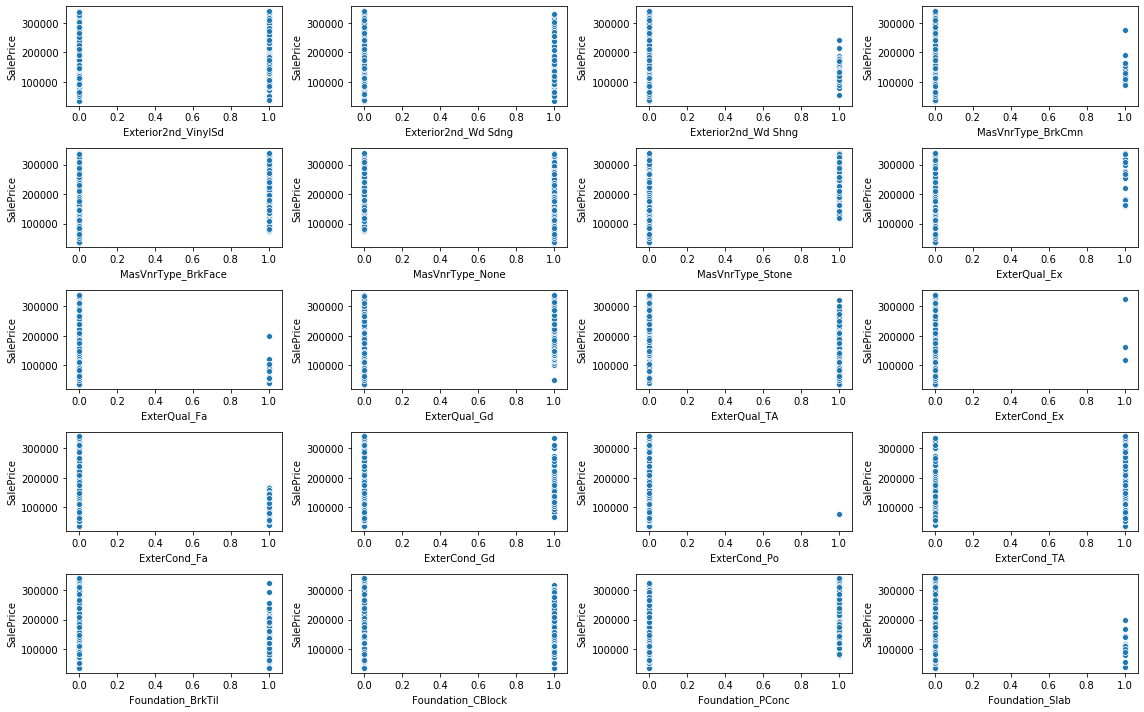

In [38]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[160:180])

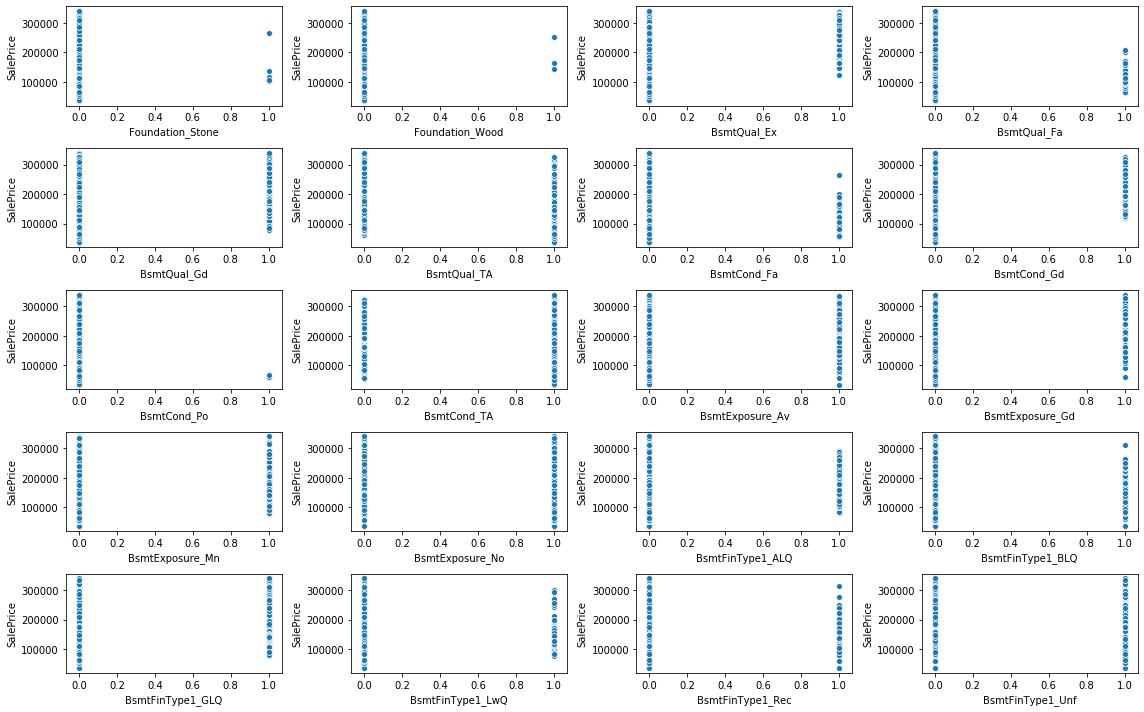

In [39]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[180:200])

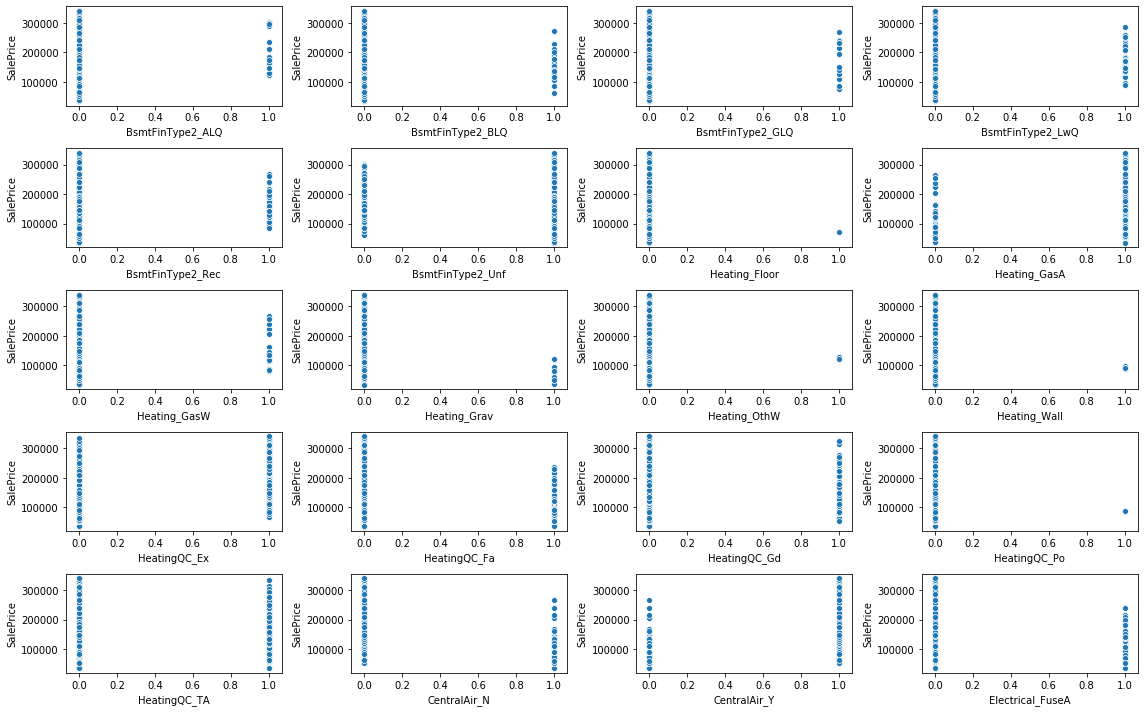

In [40]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[200:220])

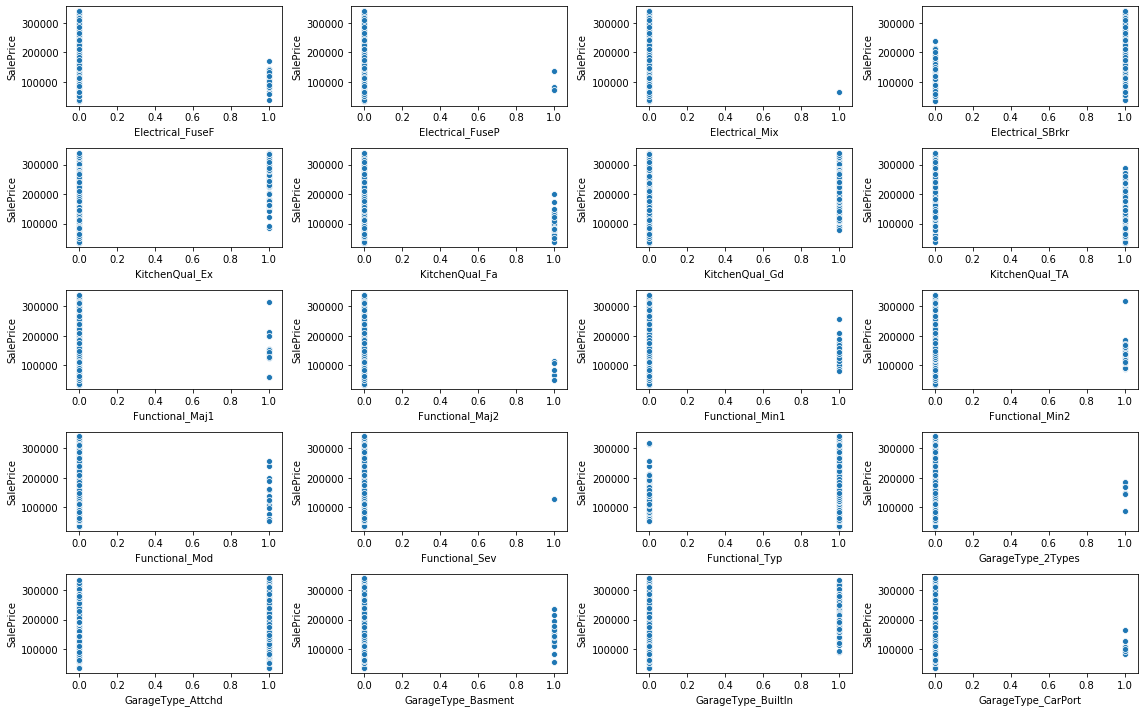

In [41]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[220:240])

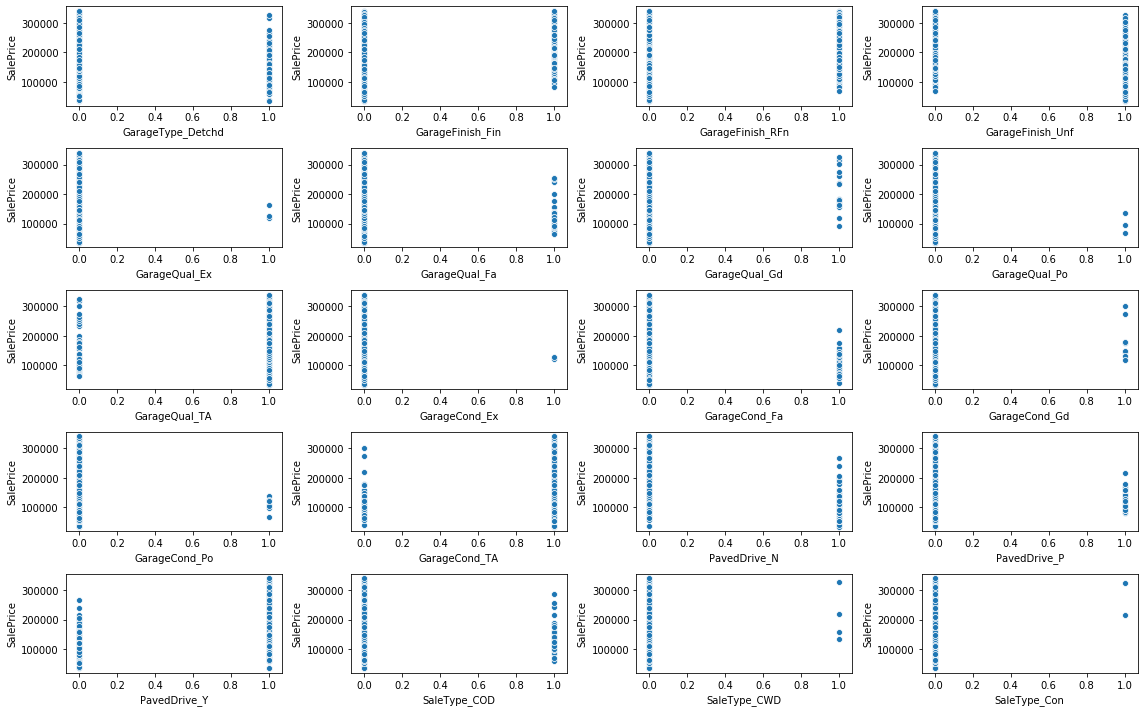

In [42]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[240:260])

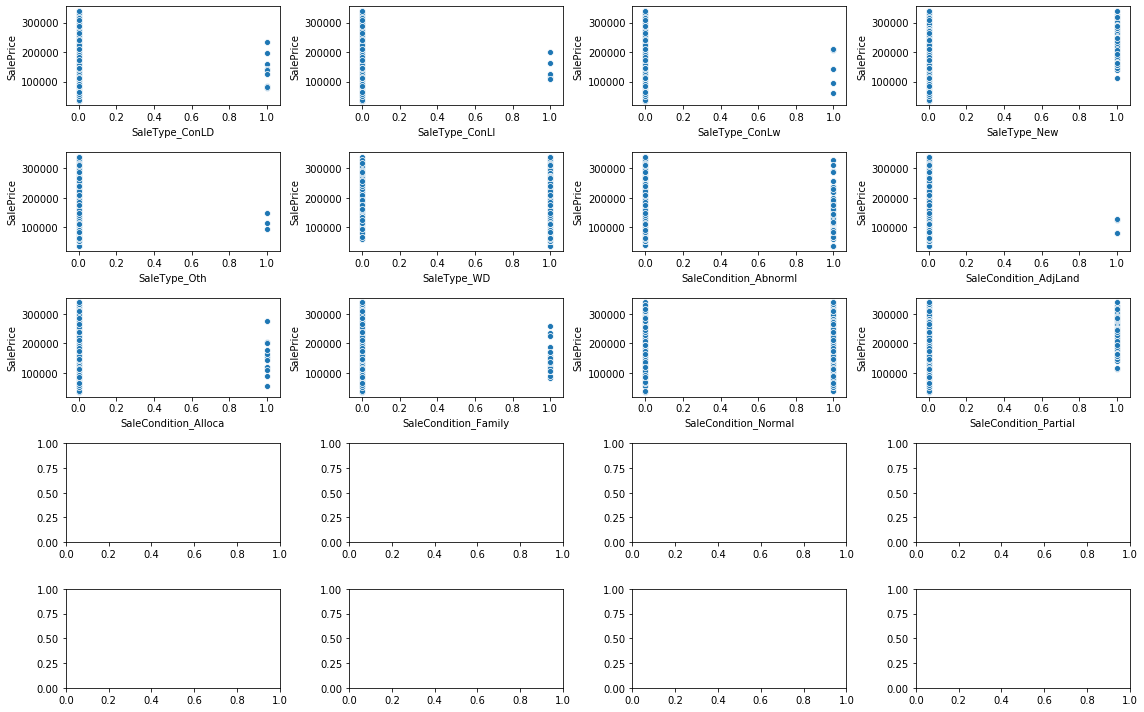

In [43]:
PlotUtil.draw_scatter_plot(rows,columns,train_df,target_variable,figsize,train_df.columns[260:280])

###### Plot Interpretation
Following features looks linearly related

- LotFrontage
- YearBuilt
- YearRemodAdd
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- BsmtUnfSF
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- GrLivArea
- GarageYrBlt
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedProch
- ScreenPorch

##### Let's check the correlation plot

In [44]:
figsize = (40,40)
#PlotUtil.draw_correlation_heatmap(train_df,figsize)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

### Feature Selection

In [45]:
threshold = .50
selected_features = FeatureSelectionUtil.correlated_features(train_df,target_variable,threshold)
selected_features

,Correlation Values
OverallQual,0.697877
YearBuilt,0.556647
YearRemodAdd,0.525288
TotalBsmtSF,0.519806
GrLivArea,0.640551
FullBath,0.545586
GarageCars,0.590731
GarageArea,0.581248
ExterQual_Gd,0.571612
ExterQual_TA,-0.584141


### Model building
#### Utility code

In [46]:
apply_y_transform = True
def get_train_test(threshold,consider_only_highly_correlated):
    
    selected_features = FeatureSelectionUtil.correlated_features(train_df,target_variable,threshold)
    cols = []
    if consider_only_highly_correlated == False:
        for cat_col in all_cat_columns:
            if cat_col not in cols:
                cols.append(cat_col)

        for sel_col in selected_features.index:
            if sel_col not in cols:
                cols.append(sel_col)
    else:
        cols = selected_features.index.values

    correlated_data = train_df[cols]
    X = correlated_data
    y = train_df[target_variable]
    if apply_y_transform == True:
        y = np.log(y)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
    
    return [X_train, X_test, y_train, y_test,cols]

#### Let's consider a set of models with continuous variables having more than 50% correlation

In [47]:
models = [LinearRegression,Lasso,Ridge,ElasticNet,DecisionTreeRegressor,RandomForestRegressor,BaggingRegressor]

In [48]:
threshold = .50
X_train, X_test, y_train, y_test,selected_features = get_train_test(threshold,True)

for algo in models:
    model = algo()
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    additional_info = {
        "correlation_threshold": threshold
    }
    metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features,additional_info,y_test,y_predict)
metrics_df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575


#### Let's consider a set of models with continuous variables having more than 55% correlation

In [49]:
threshold = .55
X_train, X_test, y_train, y_test, selected_features = get_train_test(threshold,True)

for algo in models:
    model = algo()
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    additional_info = {
        "correlation_threshold": threshold
    }
    metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


#### Let's try some algorithms with hyperparameter tuned

In [81]:
threshold = .55
X_train, X_test, y_train, y_test, selected_features = get_train_test(threshold,True)
blended_array = []

##### RandomForestRegressor

In [82]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
rf_clf = RandomForestRegressor(random_state = 42)

params_grid = { 
                'max_depth' : [3,None],
                'min_samples_split' : [2,4,6,8,10],
                'min_samples_leaf':[2,4,6,8,10],
                'bootstrap':[True,False],
                'oob_score':[True,False],
                'criterion':['mse','rmse']}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

-0.03628364081483416

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [83]:
model = RandomForestRegressor(bootstrap = True, ccp_alpha = 0.0, criterion = 'mse', max_depth = None,
                             max_features = 'auto',
                             max_leaf_nodes = None,max_samples = None,min_impurity_decrease = 0.0,
                             min_impurity_split = None,min_samples_leaf = 2,min_samples_split = 10,
                             min_weight_fraction_leaf = 0.0,n_estimators = 100,n_jobs = None,
                             oob_score = True,random_state = 42,verbose = 0,warm_start = False)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)
test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_rfr_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### Lasso

In [84]:
Lasso()

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
rf_clf = Lasso(random_state = 42)

params_grid = { 'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,5.0,10.0,20.0,30.0],
                'normalize':[True,False],
                'positive':[True,False],
                'precompute':[True,False],
                'fit_intercept':[True,False]}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:    1.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=42,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0],
                         'fit_intercept': [True, False],
                         'normalize': [True, False], 'positive': [True, False],
                         'precompute': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

-0.05971895393154836

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': True,
 'precompute': True,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [85]:
model = Lasso(alpha=0.1,normalize=False,fit_intercept=True,positive=True,random_state=42)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)
test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_lasso_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=True, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### Ridge

In [86]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
rf_clf = Ridge(random_state = 42)

params_grid = { 'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,5.0,10.0,20.0,30.0],
                'normalize':[True,False],
                'fit_intercept':[True,False]}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

-0.04006510217491317

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': 42,
 'solver': 'auto',
 'tol': 0.001}

In [87]:
model = Ridge(alpha=1.0,normalize=False,random_state=42)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)
test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_ridge_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='auto', tol=0.001)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### ElasticNet

In [88]:
ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [61]:
rf_clf = ElasticNet(random_state = 42)

params_grid = { 'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,5.0,10.0,20.0,30.0],
                'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                'normalize':[True,False]}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=42, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0, 2.0, 3.0, 5.0, 10.0, 20.0, 30.0],
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1.0],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

-0.042496748989218985

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [89]:
model = ElasticNet(alpha=0.1,normalize=False,random_state=42,l1_ratio=0.1)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)

test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_en_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=42, selection='cyclic', tol=0.0001, warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### Linear Regression

In [63]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
rf_clf = LinearRegression()

params_grid = { 
                'fit_intercept' : [True,False],
                'normalize':[True,False]}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

-0.04007574624394057

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}

In [90]:
model = LinearRegression(normalize=True)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)
test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_lr_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### DecisionTreeRegressor

In [66]:
DecisionTreeRegressor()

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [67]:
rf_clf = DecisionTreeRegressor(random_state = 42)

params_grid = { 
                'ccp_alpha' : [0.0,0.4,0.8,1.0],
                'max_depth' : [3,None],
                'min_samples_split' : [2,3,4,5,6,7,8,9,10],
                'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
                'criterion':['mse','rmse']}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4792 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   11.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=42, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.4, 0.8, 1.0],
                         'criterion': ['mse', 'rmse'], 'max_depth': [3, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7

-0.04491285444324191

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 42,
 'splitter': 'best'}

In [91]:
model = DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=2)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)

test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_decision_tree_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### BaggingRegressor

In [92]:
BaggingRegressor()

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [70]:
rf_clf = BaggingRegressor(random_state = 42)

params_grid = { 
                'bootstrap' : [True,False],
                'bootstrap_features' : [True,False],
                'max_features' : [1.0,5.0,10.0],
                'max_samples':[1.0,5.0,10.0],
                'oob_score':[True,False]}

grid_search = GridSearchCV(rf_clf,params_grid,n_jobs=-1,cv=5,verbose=1,scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
grid_search.best_score_
grid_search.best_estimator_.get_params()

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    0.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_features': [1.0, 5.0, 10.0],
                         'max_samples': [1.0, 5.0, 10.0],
                         'oob_score': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

-0.039417902011018136

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': True,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [93]:
model = BaggingRegressor(bootstrap=True, bootstrap_features=True, oob_score=True)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
final_result = model.predict(test_df[selected_features])
if apply_y_transform == True:
    final_result = pow(math.e,final_result)
blended_array.append(final_result)

test_df['SalePrice'] = final_result
test_df[['Id','SalePrice']].to_csv('house_predictions_bagging_hyper.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)

additional_info = {
    "correlation_threshold": threshold
}
metrics_df = RegressionMetricsUtil.performance_metrics(model,selected_features, additional_info,y_test,y_predict)
metrics_df

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=True,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=True, random_state=None, verbose=0,
                 warm_start=False)

,algorithm,feature_count,features_names,additional_info,r2_score,mae_score,mse_score,rmse_score,log_rmse_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.696965,0.123732,0.0310129,0.176105,0.0146558
1,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
2,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.697711,0.123816,0.0309365,0.175888,0.0146371
3,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},-0.000755558,0.25398,0.102418,0.320029,0.0267732
4,"DecisionTreeRegressor(ccp_alpha=0.0, criterion...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.532287,0.154002,0.0478662,0.218783,0.0184539
5,"RandomForestRegressor(bootstrap=True, ccp_alph...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.760839,0.114544,0.024476,0.156448,0.0131173
6,"BaggingRegressor(base_estimator=None, bootstra...",14,['OverallQual' 'YearBuilt' 'YearRemodAdd' 'Tot...,{'correlation_threshold': 0.5},0.742488,0.118729,0.026354,0.162339,0.0136575
7,"LinearRegression(copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680727,0.129961,0.0326747,0.180761,0.0150336
8,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},-0.000755558,0.25398,0.102418,0.320029,0.0267732
9,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",7,['OverallQual' 'YearBuilt' 'GrLivArea' 'Garage...,{'correlation_threshold': 0.55},0.680989,0.130056,0.0326479,0.180687,0.0150271


##### Blending

In [94]:
blended_array = np.array(blended_array)
blended_array = blended_array.T
blended_array.shape

(1459, 7)

In [95]:
blended_df = pd.DataFrame(blended_array)
blended_df.columns = ['RandomForestRegressor', 'Lasso', 'Ridge', 'ElasticNet','LinearRegression','DecisionTreeRegressor','BaggingRegressor']
blended_df

,RandomForestRegressor,Lasso,Ridge,ElasticNet,LinearRegression,DecisionTreeRegressor,BaggingRegressor
0,120930.797117,141973.385769,134621.452645,132651.834786,134690.258221,123704.778955,129116.974122
1,148727.969619,150724.747131,139906.005958,139036.553763,140017.722103,151904.446049,147777.758145
2,164456.402319,157667.934135,163670.850916,164484.886469,163643.429987,181117.973362,168731.383314
3,182904.793339,166659.848461,175224.127414,173851.938445,175315.038817,179948.833901,178608.787570
4,197780.538821,179251.842669,194769.727819,187710.209203,195012.532779,164392.107252,216539.439626
...,...,...,...,...,...,...,...
1454,90698.621454,124874.228717,104188.199092,107151.696989,104118.126790,87663.388833,86392.198619
1455,93918.369693,130251.533003,114796.852355,118370.995103,114715.084420,87663.388833,92858.544150
1456,137156.777237,145702.182254,138327.510980,140535.239663,138328.480363,150476.251727,164765.583408
1457,104489.177286,132968.055345,114908.338007,116509.216841,114902.448142,116986.687421,89193.748312


In [96]:
blended_df['blended_score'] = blended_df.mean(axis=1)
blended_df

,RandomForestRegressor,Lasso,Ridge,ElasticNet,LinearRegression,DecisionTreeRegressor,BaggingRegressor,blended_score
0,120930.797117,141973.385769,134621.452645,132651.834786,134690.258221,123704.778955,129116.974122,131098.497373
1,148727.969619,150724.747131,139906.005958,139036.553763,140017.722103,151904.446049,147777.758145,145442.171824
2,164456.402319,157667.934135,163670.850916,164484.886469,163643.429987,181117.973362,168731.383314,166253.265786
3,182904.793339,166659.848461,175224.127414,173851.938445,175315.038817,179948.833901,178608.787570,176073.338278
4,197780.538821,179251.842669,194769.727819,187710.209203,195012.532779,164392.107252,216539.439626,190779.485453
...,...,...,...,...,...,...,...,...
1454,90698.621454,124874.228717,104188.199092,107151.696989,104118.126790,87663.388833,86392.198619,100726.637213
1455,93918.369693,130251.533003,114796.852355,118370.995103,114715.084420,87663.388833,92858.544150,107510.681080
1456,137156.777237,145702.182254,138327.510980,140535.239663,138328.480363,150476.251727,164765.583408,145041.717947
1457,104489.177286,132968.055345,114908.338007,116509.216841,114902.448142,116986.687421,89193.748312,112851.095908


In [98]:
sel_df = blended_df[['Lasso','Ridge','ElasticNet','LinearRegression']]
sel_df['blended_score'] = sel_df.mean(axis=1)
sel_df

,Lasso,Ridge,ElasticNet,LinearRegression,blended_score
0,141973.385769,134621.452645,132651.834786,134690.258221,135984.232855
1,150724.747131,139906.005958,139036.553763,140017.722103,142421.257239
2,157667.934135,163670.850916,164484.886469,163643.429987,162366.775377
3,166659.848461,175224.127414,173851.938445,175315.038817,172762.738284
4,179251.842669,194769.727819,187710.209203,195012.532779,189186.078117
...,...,...,...,...,...
1454,124874.228717,104188.199092,107151.696989,104118.126790,110083.062897
1455,130251.533003,114796.852355,118370.995103,114715.084420,119533.616220
1456,145702.182254,138327.510980,140535.239663,138328.480363,140723.353315
1457,132968.055345,114908.338007,116509.216841,114902.448142,119822.014584


In [99]:
test_df['SalePrice'] = sel_df['blended_score']
test_df[['Id','SalePrice']].to_csv('house_predictions_blended_avg.csv',index=False)
test_df.drop('SalePrice',axis=1,inplace=True)